In [ ]:
# Analyze the results of the pump-probe experiments, for several Fermi energies.
# Here the evolution is calculated at variable delay, and for each Fermi energy
# it is taken the delay that yields the largest THG, i.e. the peak value.

In [1]:
import time
import math
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.optimize import minimize
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime
import multiprocessing as mp
import glob

In [2]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

In [3]:
from models.graphene_optics import GrapheneTHG

In [4]:
# Load the data of the time-evolution.

runDir = "./data/04/2023-08-19-08-26-12_gamma_fit"
eF_list = np.loadtxt("%s/eF_list.csv" % runDir, delimiter=", ")
pr_delay_list = np.loadtxt("%s/delay_list.csv" % runDir, delimiter=", ")
thg_data_list = []
thg0_data_list = []
for i_eF in range(len(eF_list)):
    with open("%s/thg_data-%02d.json" % (runDir, i_eF), "r") as f:
        thg0_data_list.append(json.load(f))
    for i_delay in range(len(pr_delay_list)):    
        with open("%s/thg_data-%02d-%02d.json" % (runDir, i_eF, i_delay), "r") as f:
            thg_data_list.append(json.load(f))

In [5]:
# The functions to calculate Gamma and the THG based on the evolutions.

def gamma_func_from_coeffs(c):
    f = lambda e: (c[0] + c[1] * e + c[2] * e**2 + c[3] / e + c[4] / e**2)
    return f


def oneTHG(x):
    thg = GrapheneTHG(**x["init"])
    thg.calculate_eta(**x["calc"])
    eta = thg.p["eta"]
    return (x["i"], eta)


def calculate_thg(thg_data, gamma_func):
    # The parameters for the THG in time, during the probe pulse. 
    params_list = []
    for i,args in enumerate(thg_data["args"]):
        # Calculate the correct value of Gamma given the chemical potentials.
        # mu_avg = 0.5 * (np.abs(args["muC"]) + np.abs(args["muV"]))
        mu_avg = np.abs(args["muC"])
        gamma = gamma_func(np.array([mu_avg]))[0]  # works with arrays
        # Prepare the parameters for one calculation of the THG.
        params = {}
        params["i"] = i
        params["init"] = {**thg_data["init"], "gammaConst": gamma, "gammaProp": 0.0, "gammaInv": 0.0}
        params["calc"] = args.copy()
        params_list.append(params)
    
    # Run the calculation.
    with mp.Pool(24) as p:
        res_list = p.map(oneTHG, params_list)

    # The THG in time.
    thg_t = np.zeros(len(thg_data["time"]))
    for res in res_list:
        thg_t[res[0]] = res[1]
    
    # Time-average of the THG.
    tt = np.array(thg_data["time"])
    thg_avg = simps(thg_t, tt) / (tt[-1] - tt[0])
    return thg_avg

In [8]:
saveDir = "./data/07/fits"

NameError: name 'saveDir' is not defined

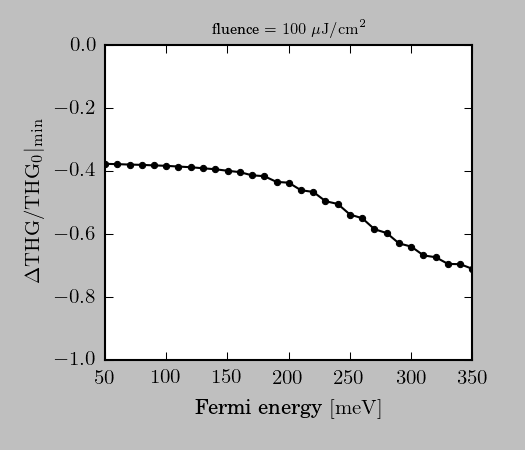

In [7]:
# Coefficients of the Gamma function.
gamma_coeffs = [0.17, 0.0, 0.0, 0.002, 0.0]
gamma_func = gamma_func_from_coeffs(gamma_coeffs)
# Calculate the THG as a function of the delay, for all Fermi energies.
thg_df = np.array([calculate_thg(thg_data, gamma_func) for thg_data in thg_data_list]).reshape((len(eF_list),len(pr_delay_list)))
# Calculate the reference THG without the pump, for all Fermi energies.
thg0_df = np.array([[calculate_thg(thg_data, gamma_func) for thg_data in thg0_data_list]]).T
# For each Fermi energy, find the signal minimum as the delay varies.
signal_min = np.array([thg.min() for thg in thg_df])
# Calculate "differential" THG signal.
dthg_df = (thg_df - thg0_df) / thg0_df
# For each Fermi energy, find the minimum of the differential signal.
# Since the signal is by definition zero before the pulse, this is
# the modulation of the thg.
modulation = np.array([dthg.min() for dthg in dthg_df])

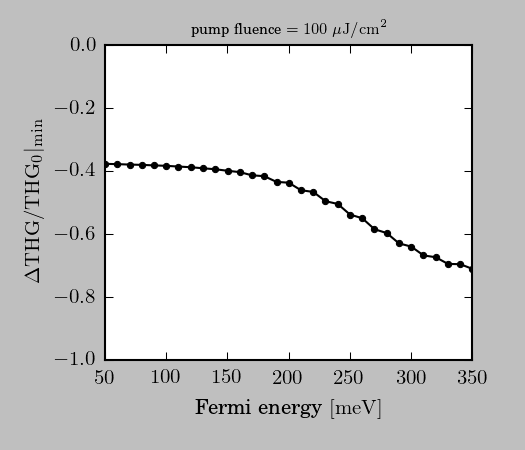

In [10]:
# Plot the modulation as a function of the Fermi energy.
mpl.style.use(["classic", "latex"])
plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
plt.axes([0.2, 0.2, 0.7, 0.7])
plt.plot(eF_list * 1.0e+3, modulation, "-ok", ms=3.0)
#plt.xlim([0.0, 1.0])
plt.ylim([-1.0, 0.0])
plt.xlabel(r"Fermi energy $[{\rm meV}]$")
# plt.ylabel(r"$\eta_{\rm THG}$")
plt.ylabel(r"$\Delta{\rm THG}/{\rm THG}_{0}\vert_{\rm min}$")
plt.title(r"\scriptsize $\mbox{pump fluence} = 100~\mu{\rm J}/{\rm cm}^{2}$")
plt.savefig("%s/modulation_eF_100.png" % saveDir, dpi=300)